# Caption
This is a demonstration of a calculation that we will likely use in our final project submission. For this demonstration, we downloaded the temperature data for ASOS stations in Texas as [asos.csv](https://github.tamu.edu/samgardner4/climo-dreamteam/blob/master/asos.csv). This python script reads asos.csv, filters the station data to only the days during the 2021 cold snap (Feb 14 through 18, 2021), averages the temperatures across all stations over the timeframe of the event. Then, the average temperature at each station is compared to the average temperature across the whole state, generating a "deviation from average". These deviations are then plotted on a map of Texas. 

UHI effects are clearly present in the Houston/Galveston, Dallas/Fort Worth, and Austin/San Antonio areas.

Source for data: https://mesonet.agron.iastate.edu/request/download.phtml?network=TX_ASOS

Thanks and gig'em!


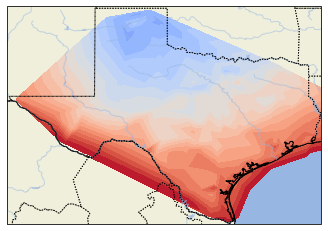

In [1]:
#!/usr/bin/env python
# Graphic Demo for ATMO 324 by Sam Gardner <stgardner4@tamu.edu>, 
# Drew Davis <acdavis01@tamu.edu>, Ashley Palm <ashleyp0301@tamu.edu>


#import libs
import csv
import datetime as dt
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
%matplotlib inline
from cartopy import crs as ccrs
from cartopy import feature as cfeat
import numpy as np

# Read csv data
validReports = list()

with open("asos.csv") as asosCSVFile:
    csvRead = csv.DictReader(asosCSVFile, delimiter=",")
    for row in csvRead:
        if (row["tmpc"] != "null"):
            validReports.append(row)
# make dates in csv use datetime objects
targetDates = [dt.datetime(2021, 2, 14, 0, 0, 0),
               dt.datetime(2021, 2, 15, 0, 0, 0), 
               dt.datetime(2021, 2, 16, 0, 0, 0),
               dt.datetime(2021, 2, 17, 0, 0, 0), 
               dt.datetime(2021, 2, 18, 0, 0, 0)]
reportsOnTargetDates = list()
tempsOnTargetDates = list()
for targetDT in targetDates:
    targetDateStr = targetDT.strftime("%Y-%m-%d")
    for report in validReports:
        if targetDateStr in report["valid"]:
            tempsOnTargetDates.append(float(report["tmpc"]))
            reportsOnTargetDates.append(report)
# Get overall average temperature during event
averageTempAllStations = sum(tempsOnTargetDates) / len(tempsOnTargetDates)

# Create list of dicts for all reports we're interested in
deviationRpts = list()
dictOfStations = dict()
for targetedReport in reportsOnTargetDates:
    deviationReport = { "Station ID" : targetedReport["station"],
                       "Date/Time" : targetedReport["valid"],
                       "Latitude" : targetedReport["lat"],
                       "Longitude" : targetedReport["lon"],
                       "Temp deviation" : 
                       float(float(targetedReport["tmpc"]) 
                             - averageTempAllStations)}
    deviationRpts.append(deviationReport)
    if targetedReport["station"] not in dictOfStations.keys():
        stationDict = { "lat" : targetedReport["lat"], 
                       "lon" : targetedReport["lon"] }
        dictOfStations[targetedReport["station"]] = stationDict

# Get average deviation for each station across the event 
# maybe don't do this in the future
# ...could use an animated GIF instead of single frame to show change over time
stationList = dictOfStations.keys()
latList = list()
lonList = list()
deviationList = list()
for station in stationList:
    latList.append(dictOfStations[station]["lat"])
    lonList.append(dictOfStations[station]["lon"])
    rollingSum = 0.0
    numOfRpts = 0
    for targetReport in deviationRpts:
        if targetReport["Station ID"] == station:
            rollingSum = rollingSum + targetReport["Temp deviation"]
            numOfRpts = numOfRpts + 1
    deviationAvg = (rollingSum / numOfRpts)
    deviationList.append(deviationAvg)

## interpolate individual stations into mesh covering the whole area
# get min/max bounds
latmin = 25.837377
latmax = 36.600704
lonmin = -106.745646
lonmax = -93.508292
# create mesh
lonGrid = np.linspace(lonmin, lonmax, 1000)
latGrid = np.linspace(latmin, latmax, 1000)
lonGrid, latGrid = np.meshgrid(lonGrid, latGrid)
# get interpolated data
tempGrid = griddata((lonList, latList), 
                    deviationList, 
                    (lonGrid, latGrid), method="linear")



# Create plot figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertCylindrical())

ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.BORDERS, linestyle="-")
ax.add_feature(cfeat.LAKES, alpha=0.5)
ax.add_feature(cfeat.RIVERS, alpha=0.5)
ax.add_feature(cfeat.STATES, linestyle=":")
ax.set_extent((lonmin, lonmax, latmin, latmax))

ax.contourf(lonGrid,
            latGrid,
            tempGrid,
            transform=ccrs.PlateCarree(),
            levels=np.arange(-15, 10, 1),
            cmap="coolwarm")

fig
print("Thanks and gig'em!")